In [1]:
from fastbook import *
from fastai.vision.widgets import *
import sys
sys.path.append('../src')  # 添加上一级目录到 Python 路径
import warnings
warnings.filterwarnings('ignore')

In [35]:
# 利用bing搜索引擎下载bears图像
# crawler_images_bing 是否具有优化的空间？！
from crawlerImages import *

bear_types = 'grizzly','black','teddy'
path = Path('../bears')

crawler_images_bing(bear_types, path)

In [36]:
fns = get_image_files(path)
fns

(#484) [Path('../bears/grizzly/3a77f2cc-ada1-4a0b-819b-0c4ec2f913df.jpg'),Path('../bears/grizzly/4974d08c-75d4-4c64-b0ff-688405099c9a.jpg'),Path('../bears/grizzly/4263ed34-9813-43aa-8b2e-3bcc9faa8e9b.jpg'),Path('../bears/grizzly/6515730b-04de-4ee6-aa01-36f152a2a80e.jpg'),Path('../bears/grizzly/81f09f7e-25fe-4163-90ba-23aa7ee62d1e.jpg'),Path('../bears/grizzly/da03a367-2202-4b03-83e8-0c266e8beb1e.jpg'),Path('../bears/grizzly/9dc7aa04-a138-46ce-9355-03b230a6e960.jpg'),Path('../bears/grizzly/b7c43ee6-0acb-4918-88a7-8c7e876ce018.jpg'),Path('../bears/grizzly/b200c34c-d684-4e87-aa0c-9382ca571871.jpg'),Path('../bears/grizzly/753549fb-4287-4ecc-bc36-0ed5a859221f.jpg'),Path('../bears/grizzly/2b488a98-5107-41a8-a45d-77e2a4c1bb5e.jpg'),Path('../bears/grizzly/10b86ba8-3bdd-4f72-bb02-0035637dceca.jpg'),Path('../bears/grizzly/6fdec99e-d52b-420d-b54d-13137e50a436.jpg'),Path('../bears/grizzly/ed2b2e34-e039-4919-b42b-06887e003e0d.jpg'),Path('../bears/grizzly/79f6a68f-d44a-4240-896f-565c11a5a1ab.jpg'),Pa

In [37]:
failed = verify_images(fns)
failed

(#33) [Path('../bears/grizzly/3a77f2cc-ada1-4a0b-819b-0c4ec2f913df.jpg'),Path('../bears/grizzly/81f09f7e-25fe-4163-90ba-23aa7ee62d1e.jpg'),Path('../bears/grizzly/ed2b2e34-e039-4919-b42b-06887e003e0d.jpg'),Path('../bears/grizzly/3fe57be8-969d-4c26-8ad5-14d7208abfcd.jpg'),Path('../bears/grizzly/85cbd03d-7121-42e5-96cb-704f39229d32.JPG'),Path('../bears/grizzly/1635f5da-e8e5-4865-9189-757f1329b551.jpg'),Path('../bears/grizzly/9a030282-650f-4069-b50d-c233e90b278a.jpg'),Path('../bears/grizzly/737f06a2-7984-4ea0-a3d6-ff74dac9705e.png'),Path('../bears/grizzly/9f532347-12ad-4d2a-a558-bad7d4542760.png'),Path('../bears/grizzly/8fbfea25-bf62-4c0b-b69c-1f09b915b3e7.jpg'),Path('../bears/grizzly/d623e5de-93df-4af2-977f-ea4e11e5c649.jpg'),Path('../bears/black/2310e4ff-96f9-4fd4-8362-c93945b46388.jpg'),Path('../bears/black/d4e1f37e-dd09-4cab-823d-1035ccd5e64c.jpg'),Path('../bears/black/3110156d-e40b-4349-8a61-15bff2ee8854.JPG'),Path('../bears/black/e2d6b1dd-92f8-4416-9214-fddf0693d713.jpg'),Path('../be

In [5]:
??verify_images

Signature: verify_images(fns)
Source:   
def verify_images(fns):
    "Find images in `fns` that can't be opened"
    return L(fns[i] for i,o in enumerate(parallel(verify_image, fns)) if not o)
File:      /opt/homebrew/Caskroom/miniforge/base/envs/smartbook/lib/python3.10/site-packages/fastai/vision/utils.py
Type:      function

In [6]:
failed.map(Path.unlink);

In [7]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

# blocks=(ImageBlock, BBoxBlock, BBoxLblBlock)  # 图像、边界框、边界框标签
# blocks=(ImageBlock, CategoryBlock)  # 输入是图像，输出是分类标签

In [9]:
dls = bears.dataloaders(path)

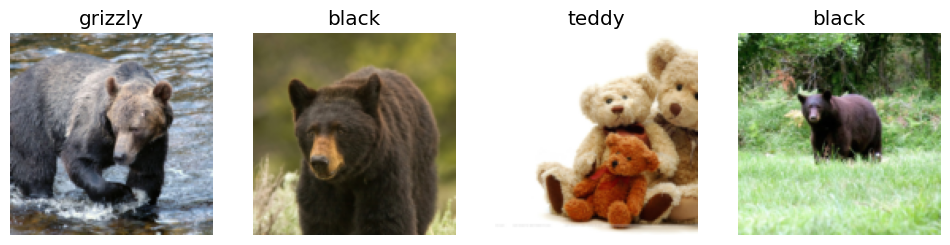

In [10]:
dls.valid.show_batch(max_n=4, nrows=1)

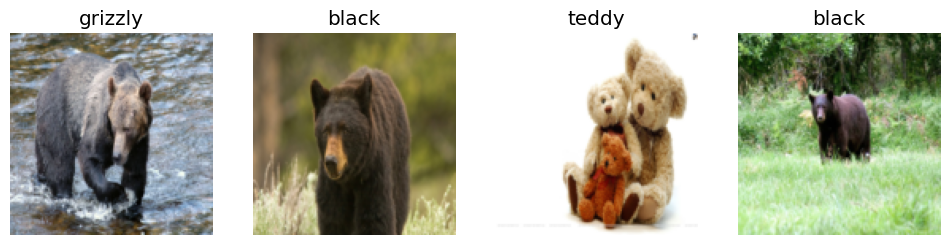

In [11]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

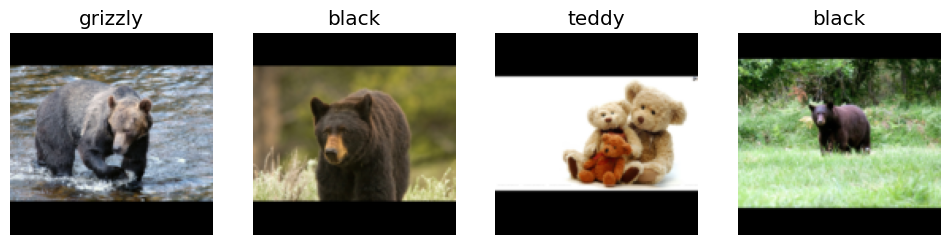

In [12]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

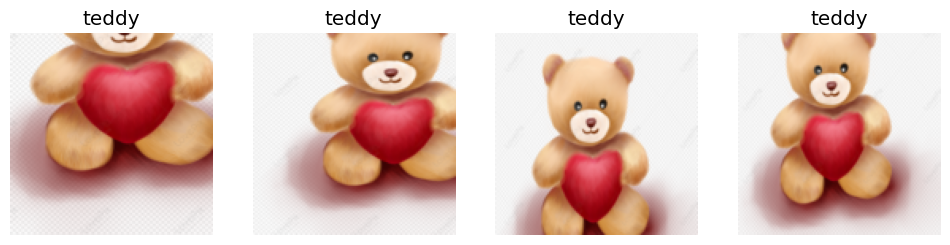

In [13]:
# min_scale=0.3 表示在进行随机裁剪前，会从原始图像中随机选择一个区域，这个区域的面积最小是原始图像面积的 30%
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

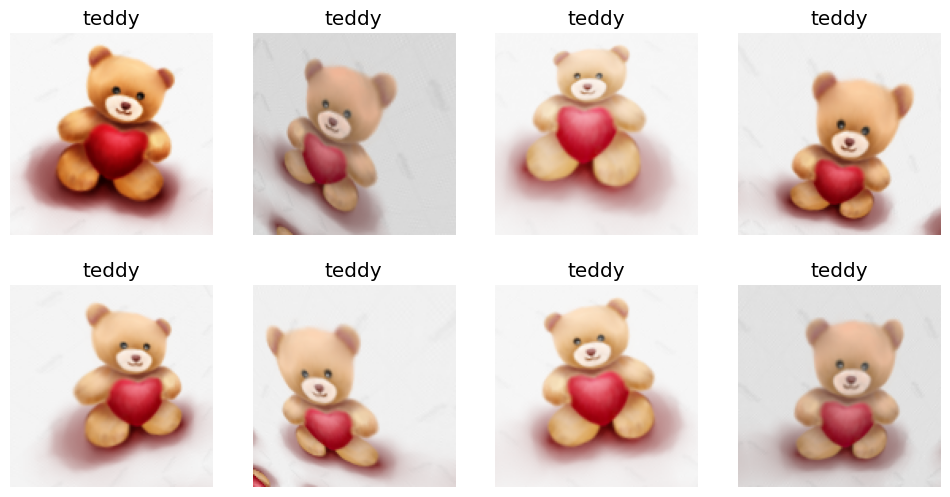

In [14]:
# aug_transforms() 是 FastAI 提供的一个便捷函数，会自动生成一组常用的图像增强变换（如随机翻转、旋转、缩放、亮度 / 对比度调整等）
# mult=2 表示将这些增强操作的强度放大到默认值的 2 倍
# 当 mult=2 时，所有增强操作的参数范围都会加倍，例如：
# 旋转角度范围会从默认的 ±10° 变为 ±20°
# 缩放范围会从默认的 1±0.1 变为 1±0.2
# 亮度 / 对比度的调整幅度也会相应增加
# 使用 aug_transforms 进行数据增强后，原始数据的总数量不会增加。
# 数据增强（包括 aug_transforms）的工作方式是：
# 在模型训练过程中，动态地对原始数据进行随机变换（如随机翻转、旋转等）
# 每次迭代时，同一个原始样本会被转换成不同的增强版本
# 但这些增强后的样本是临时生成的，不会被保存到磁盘，也不会增加原始数据集的样本总数
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [15]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [16]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.469049,0.201008,0.058824,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.218756,0.114439,0.023529,00:06
1,0.165495,0.074179,0.023529,00:06
2,0.125314,0.060634,0.011765,00:07
3,0.106063,0.027855,0.011765,00:07
4,0.085665,0.022087,0.011765,00:06
5,0.070967,0.021405,0.023529,00:06
6,0.058266,0.023301,0.023529,00:07
7,0.051447,0.016533,0.000000,00:07
8,0.043940,0.014281,0.000000,00:07
9,0.038212,0.013829,0.000000,00:06


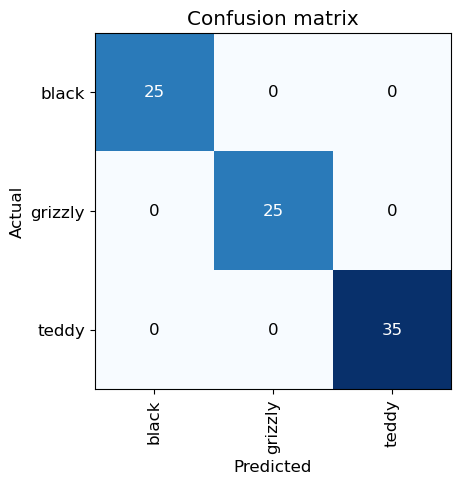

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

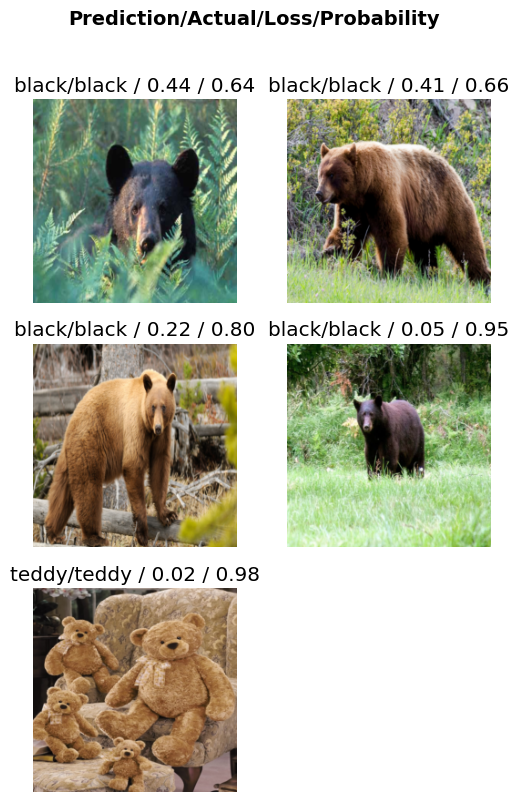

In [18]:
interp.plot_top_losses(5, nrows=3)

In [19]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [20]:
learn.export()

In [21]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [22]:
learn_inf = load_learner(path/'export.pkl')

In [23]:
learn_inf.predict('../images/grizzly.jpg')

('grizzly', tensor(1), tensor([2.1101e-06, 1.0000e+00, 5.4438e-08]))

In [24]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [25]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [26]:
btn_upload = SimpleNamespace(data = ['../images/grizzly.jpg'])

In [27]:
img = PILImage.create(btn_upload.data[-1])

In [28]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [29]:
pred,pred_idx,probs = learn_inf.predict(img)

In [30]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx].item():.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 1.0000')

In [31]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [32]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [33]:
btn_upload = widgets.FileUpload()

In [34]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [38]:
!pip install Voilà. -i 国内源
(smartbook) hai@YH-MBP-M4 ~/.fastai/archive$ jupyter labextension list | grep voila              
JupyterLab v4.4.3
/opt/homebrew/Caskroom/miniforge/base/envs/smartbook/share/jupyter/labextensions
        jupyterlab_pygments v0.3.0 enabled OK (python, jupyterlab_pygments)
        @jupyter-notebook/lab-extension v7.4.3 enabled OK
        @voila-dashboards/jupyterlab-preview v2.3.10 enabled OK (python, voila)
        @jupyter-widgets/jupyterlab-manager v3.1.11 enabled OK (python, jupyterlab_widgets)

voila  ipynb文件（可选）

ERROR: Invalid requirement: 'Voilà.': Expected package name at the start of dependency specifier
    Voilà.
    ^
